In [1]:
# To disable `warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)`
import warnings
warnings.filterwarnings('ignore')

## 1. What is CVXPY?

CVXPY is a Python-embedded modeling language for convex optimization problems.
It automatically transforms the problem into standard form, calls a solver, and unpacks the results.
For example,
$$
\begin{align*}
\text{minimize} &\qquad (x-y)^2 \\
\text{subject to} &\qquad x-y \geq 1 \\
&\qquad x+y = 1.
\end{align*}
$$

In [2]:
import cvxpy as cp

# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Form objective.
objective = cp.Minimize((x - y)**2)

# Create two constraints.
constraints = [x - y >= 1, x + y == 1]

# Form and solve problem.
prob = cp.Problem(objective, constraints)
prob.solve() # Returns the optimal value.

print(f"""\
status: {prob.status}
optimal value: {prob.value:f}
optimal variables:
    x = {x.value:f}
    y = {y.value:f}
""")

status: optimal
optimal value: 1.000000
optimal variables:
    x = 1.000000
    y = 0.000000



The method `solve()` returns the optimal value and updates `.status` and `.value` attributes on the problem object, and the `.value` field of all the variables in the problem.

- The status "__optimal__" tells us the problem was solved successfully.
- The optimal value "__1__" is the minimum value of the objective over all choices of variables that satisfy the constraints.
- "__1__" and "__0__" are the values of `x` and `y`, respectively, that achieve the optimal objective.

### Changing the problem

`cvxpy.Problem`s are <u>immutable</u>, meaning they cannot be changed after they are created.
To change the objective or constraints, create a new problem.

In [3]:
# Replace the objective.
prob2 = cp.Problem(cp.Maximize(x + y), prob.constraints)
print(f"optimal value of prob2: {prob2.solve():f}")

# Replace the 2nd constraint x + y == 1.
constraints = prob2.constraints[:1] + [x + y <= 3]
prob3 = cp.Problem(prob2.objective, constraints)
print(f"optimal value of prob3: {prob3.solve():f}")

optimal value of prob2: 1.000000
optimal value of prob3: 3.000000


### Infeasible and unbounded problems

If a problem is infeasible or unbounded, the status field will be set to "__infeasible__" or "__unbounded__", respectively.
The value fields of the problem variables are not updated.
For example,
$$
\begin{align*}
\text{minimize} &\qquad x \\
\text{subject to} &\qquad x \geq 1, \quad x \leq 0.
\end{align*}
$$
is infeasible, but the unconstrained problem "minimize $x$" is unbounded.

- For minimization problems, the optimal value is `inf` if infeasible and `-inf` if unbounded.
- For maximization problems, the optimal value is `-inf` if infeasible and `inf` if unbounded.

In [4]:
import cvxpy as cp

x = cp.Variable()

# An infeasible problem.
prob = cp.Problem(cp.Minimize(x), [x >= 1, x <= 0])
prob.solve()

print(f"""\
status: {prob.status}
optimal value: {prob.value:f}
optimal variable: {x.value}
""")

# An unbounded problem.
prob = cp.Problem(cp.Minimize(x))
prob.solve()

print(f"""\
status: {prob.status}
optimal value: {prob.value:f}
optimal variable: {x.value}
""")

status: infeasible
optimal value: inf
optimal variable: None

status: unbounded
optimal value: -inf
optimal variable: None



### Other problem statuses

If the solver called by CVXPY <u>solves the problem but to a lower accuracy than desired</u>, the problem status indicates the lower accuracy achieved. The statuses indicating lower accuracy are

- "__optimal inaccurate__"
- "__unbounded inaccurate__"
- "__infeasible inaccurate__"

If the solver completely fails to solve the problem, CVXPY throws a `SolverError` exception.
If this happens you should try using other solvers. See the discussion of [Choosing a solver](https://www.cvxpy.org/tutorial/advanced/index.html#solvers) for details.

CVXPY provides the following constants as aliases for the different status strings:

- `OPTIMAL`
- `INFEASIBLE`
- `UNBOUNDED`
- `OPTIMAL_INACCURATE`
- `INFEASIBLE_INACCURATE`
- `UNBOUNDED_INACCURATE`

In [5]:
prob.status == cp.UNBOUNDED, prob.status == cp.UNBOUNDED_INACCURATE

(True, False)

The status `cvxpy.settings.INFEASIBLE_OR_UNBOUNDED` is rare.

- It's used when a solver was able to determine that the problem was either infeasible or unbounded, but could not tell which.
- You can determine the precise status by re-solving the problem where you set the objective function to a constant (e.g., `objective = cp.Minimize(0)`).
- If the new problem is solved with status code `INFEASIBLE_OR_UNBOUNDED` then the original problem was infeasible. 
- If the new problem is solved with status `OPTIMAL` then the original problem was unbounded.

### Vectors and matrices

`cvxpy.Variable`s can be scalars, vectors, or matrices, meaning they are 0, 1, or 2 dimensional.

In [6]:
# A scalar variable.
a = cp.Variable()

# Vector variable with shape (5,).
x = cp.Variable(5)

# Matrix variable with shape (4, 7).
A = cp.Variable((4, 7))

a, x, A

(Variable((), var112), Variable((5,), var113), Variable((4, 7), var114))

You can use your numeric library of choice to construct matrix and vector constants.
For instance, if `x` is a CVXPY Variable in the expression `A @ x + b`, `A` and `b` could be Numpy ndarrays, SciPy sparse matrices, etc. `A` and `b` could even be different types.

Currently the following types may be used as <u>constants</u>:

- NumPy ndarrays
- NumPy matrices
- SciPy sparse matrices

In [7]:
# Solves a bounded least-squares problem.

import numpy as np
import cvxpy as cp

# Problem data.
m = 10
n = 5

rng = np.random.default_rng(1)
A = rng.standard_normal((m, n))
b = rng.standard_normal(m)

# Construct the problem.
x = cp.Variable(n)

objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

print(f"""\
optimal value: {prob.solve():f}
optimal variables: (a Numpy ndarray)
    {x.value}
""")

optimal value: 1.716426
optimal variables: (a Numpy ndarray)
    [ 3.83404177e-01  9.09989000e-01  9.20222924e-02  4.93360339e-01
 -6.78466468e-22]



### Constraints

You can use `==`, `<=`, and `>=` to construct constraints in CVXPY.

<u>Equality and inequality constraints are elementwise</u>, whether they involve scalars, vectors, or matrices.

- If you want matrix inequalities that represent semidefinite cone constraints, see [Semidefinite matrices](https://www.cvxpy.org/tutorial/advanced/index.html#semidefinite).

You <u>cannot construct</u> inequalities with `<` and `>`.

You <u>cannot chain</u> constraints together, e.g., `0 <= x <= 1` or `x == y == 2`.

### Parameters

`cvxpy.Parameter`s are symbolic representations of <u>constants</u>.

- The purpose of parameters is to <u>change the value of a constant in a problem without reconstructing the entire problem</u>.
- In many cases, solving a parametrized program multiple times can be substantially faster than repeatedly solving a new problem.
- Be sure to read the tutorial on [Disciplined Parametrized Programming](https://www.cvxpy.org/tutorial/advanced/index.html#dpp) (DPP).

Parameters can be vectors or matrices, just like variables.

- When you create a parameter you have the option of specifying attributes such as the sign of the parameter's entries, whether the parameter is symmetric, etc. These attributes are used in [Disciplined Convex Programming](https://www.cvxpy.org/tutorial/dcp/index.html#dcp) and are unknown unless specified.

Parameters can be assigned a constant value any time after they are created.

- The constant value must have the same dimensions and attributes as those specified when the parameter was created.

In [8]:
# Positive scalar parameter.
m = cp.Parameter(nonneg=True)

# Column vector parameter with unknown sign (by default).
c = cp.Parameter(5)

# Matrix parameter with negative entries.
G = cp.Parameter((4, 7), nonpos=True)

# Assigns a constant value to G.
G.value = -np.ones((4, 7))

m, c, G

(Parameter((), nonneg=True), Parameter((5,)), Parameter((4, 7), nonpos=True))

You can initialize a parameter with a value. The following code segments are equivalent:

In [9]:
# Create parameter, then assign value.
rho = cp.Parameter(nonneg=True)
rho.value = 2

# Initialize parameter with a value.
rho = cp.Parameter(nonneg=True, value=2)

The example below computes a trade-off curve for a LASSO problem.

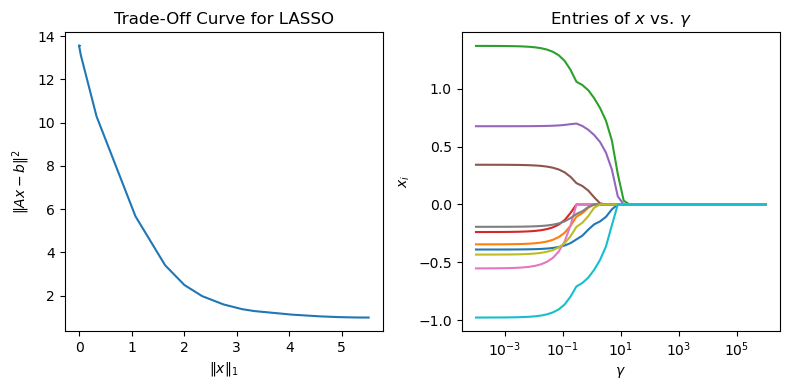

In [10]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Problem data.
n = 15
m = 10

rng = np.random.default_rng(1)
A = rng.standard_normal((n, m))
b = rng.standard_normal(n)

# gamma must be nonnegative due to DCP rules.
gamma = cp.Parameter(nonneg=True)

# Construct the problem.
x = cp.Variable(m)
error = cp.sum_squares(A @ x - b)

objective = cp.Minimize(error + gamma * cp.norm(x, p=1))
prob = cp.Problem(objective)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []

gamma_vals = np.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(cp.norm(x, p=1).value)
    x_values.append(x.value)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

# Plot trade-off curve.
ax1.plot(l1_penalty, sq_penalty)
ax1.set_xlabel("$\|x\|_1$")
ax1.set_ylabel("$\|Ax-b\|^2$")
ax1.set_title("Trade-Off Curve for LASSO")

# Plot entries of x vs. gamma.
for i in range(m):
    ax2.plot(gamma_vals, [xi[i] for xi in x_values])
ax2.set_xscale("log")
ax2.set_xlabel("$\gamma$")
ax2.set_ylabel("$x_i$")
ax2.set_title("Entries of $x$ vs. $\gamma$")

fig.tight_layout()

Trade-off curves can easily be computed in parallel. The code below computes in parallel the optimal x for each 
 in the LASSO problem above.

In [11]:
from multiprocessing import Pool

# Assign a value to gamma and find the optimal x.
def get_x(gamma_value):
    gamma.value = gamma_value
    prob.solve()
    return x.value

gamma_vals = np.logspace(-4, 6, num=100)

In [12]:
# Parallel computation (set to 1 process here).
pool = Pool(processes=1)
%timeit x_values = pool.map(get_x, gamma_vals)

198 ms ± 789 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# Parallel computation (set to 10 process here).
pool = Pool(processes=10)
%timeit x_values = pool.map(get_x, gamma_vals)

32.9 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
